In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from math import ceil, floor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from collections import defaultdict
from tqdm.auto import tqdm

import random
from sklearn.ensemble import RandomForestClassifier

import pandas_profiling
import warnings

from collections import Counter
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from mlxtend.classifier import EnsembleVoteClassifier
import pickle

from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [2]:
tokamak_data = pd.read_pickle("./final.pkl")

init_cols = [
  'abs_pohm', 'beili2', 'betmhd', 'bt', 'delta', 'epsilon', 'greenwald', 'imp_tauth', 'inv_abs_bt', 
    'inv_abs_ip', 'inv_amin', 'inv_betmhd', 'inv_bt', 'inv_greenwald', 'inv_ip', 'inv_kappa', 
    'inv_meff', 'inv_pl', 'inv_q95', 'inv_rgeo', 'inv_tauth', 'inv_tautot', 'inv_tev', 'inv_time', 
    'inv_vol', 'inv_wmhd', 'inv_wth', 'kappa', 'log_betmhd', 'log_inv_kappaa', 'log_pl', 'log_time', 
    'log_wmhd', 'meff', 'pinj', 'pl', 'pnbi', 'prad', 'q95', 'rgeo', 'tauth', 'tautot', 'time', 'wmhd', 
    'wth', 'wtot', '_abs_bt_epsilon_inv_nel', '_abs_bt_inv_abs_ip_rgeo', '_imp_prad_tok_pbxm', 
    '_inv_abs_bt_inv_rgeo_pressure', '_inv_abs_bt_inv_tev_nel', '_inv_abs_bt_nel', '_inv_abs_ip_rgeo_tev'
]

hidden_cols = ["tok", "stratify", "is_good", "walmat_c"]

tokamak_data = tokamak_data[["is_good", "tok", *init_cols]]

tokamak_data = tokamak_data[tokamak_data.tok != "TDEV"]


In [3]:
tok_list = list(tokamak_data["tok"].unique())
strat_list = []

for tok, good in zip(tokamak_data["tok"], tokamak_data["is_good"]):
    strat_list.append(tok_list.index(tok)*10 + good)
    
tokamak_data["stratify"] = strat_list

bad_markers = list(tokamak_data.stratify.value_counts()[( tokamak_data.stratify.value_counts() == 1 )].index)

assert bad_markers != 1

tokamak_data.loc[tokamak_data["stratify"].isin(bad_markers), "stratify"] = -1

In [4]:
tokamak_data.to_pickle("./modeled_data.pkl")


In [5]:
desired_dict = {
    'JET': 3083,
    'ASDEX': 1500,
    'D3D': 1250,
    'AUG': 1000,
    'CMOD': 750,
    'JFT2M': 1000,
    'PBXM': 500,
    'PDX': 500,
    'TFTR': 500,
    'JT60U': 250,
    'TCV': 100,
    'NSTX': 50
}


In [6]:
def fix_data(input_data):
    jet_ratio = np.sum(input_data.tok == "JET") / desired_dict["JET"]
    output_data = input_data.copy()
        
    for cur_key, cur_value in desired_dict.items():
        if cur_key == "JET": continue
        desired_count = int(np.ceil(cur_value * jet_ratio))

        tok_rows = output_data[output_data.tok == cur_key].copy()
        tok_count = len(tok_rows)

        output_data = output_data.append(tok_rows.sample(desired_count % tok_count))
        if desired_count < 2 * tok_count: continue     

        for cur_times in range(floor(desired_count/tok_count)-1):
            output_data = output_data.append(tok_rows.copy())
    
    output_X = output_data[[output_col for output_col in output_data.columns if output_col not in hidden_cols]]
    output_y = output_data.is_good
    
    return output_X, output_y


In [7]:
def split_data(columns=[in_col for in_col in tokamak_data.columns if in_col not in hidden_cols]):
    train_data, test_data = train_test_split(tokamak_data, test_size=0.2, stratify=tokamak_data.stratify, random_state=42)

    X_train, y_train = fix_data(train_data)
    X_test, y_test = fix_data(test_data)
    
    X_train = X_train[columns]
    X_test = X_test[columns]
    
    test_indices = X_test.index
    scaler = StandardScaler().fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=columns)
    
    return X_train, X_test, y_train, y_test, scaler, test_indices


In [8]:
def build_predictors(l1_estimator, l2_estimator, work_ps):
    warnings.filterwarnings('ignore')

    X_train, X_test, y_train, y_test, X_scaler, test_indices = split_data();

    selector = RFECV(l1_estimator, step=0.2, cv=4)
    selector = selector.fit(X_train, y_train)

    print([selector.score(X_train, y_train),selector.score(X_test, y_test)])
    reduced_columns = X_train.columns[selector.support_]
    
    X_train, X_test, y_train, y_test, X_scaler, test_indices = split_data(reduced_columns)

    if len(work_ps) == 0:
        clf = l2_estimator
    else:
        clf = GridSearchCV(l2_estimator, work_ps, cv=3)
        
    clf.fit(X_train, y_train)

    warnings.resetwarnings()
    
    print([clf.score(X_train, y_train),clf.score(X_test, y_test)])
    
    if len(work_ps) == 0:
        return_clf = clf
    else:
        return_clf = clf.best_estimator_
        
    return selector, return_clf, X_scaler, reduced_columns, test_indices


In [9]:
def train_tree(forest_fit):
    train_data, test_data = train_test_split(tokamak_data, test_size=0.2, stratify=tokamak_data.stratify, random_state=42)
    
    X_train, y_train = fix_data(train_data)
    X_test, y_test = fix_data(test_data)

    columns = X_train.columns
    test_indices = X_test.index
    
    scaler = StandardScaler().fit(X_train)

    X_train = pd.DataFrame(scaler.transform(X_train), columns=columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=columns)

    forest_fit.fit(X_train, y_train)

    print([forest_fit.score(X_train, y_train),forest_fit.score(X_test, y_test)])
    return forest_fit, forest_fit, scaler, columns, test_indices


In [10]:
svm_l1 = LinearSVC(penalty="l1", dual=False, max_iter=10000)
svm_l2 = CalibratedClassifierCV(LinearSVC(max_iter=10000), cv=4)
svm_ps = {}

log_l1 = LogisticRegression(penalty='l1', solver='saga', max_iter=10000, n_jobs=-1)
log_l2 = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1)
log_ps = {'C': [0.05, 0.5, 5, 50]}

In [11]:
print("log")
log_lasso, log_ridge, log_scaler, log_cols, log_test = build_predictors(log_l1, log_l2, log_ps)

print("svm")
svm_lasso, svm_ridge, svm_scaler, svm_cols, svm_test = build_predictors(svm_l1, svm_l2, svm_ps)

print("for")
for_classifier = RandomForestClassifier(n_estimators=20000, random_state=42, n_jobs=-1)
for_lasso, for_ridge, for_scaler, for_cols, for_test = train_tree(for_classifier)

print("xgb")
xgb_classifier = XGBClassifier(n_estimators=20000, random_state=42, n_jobs=-1)
xgb_lasso, xgb_ridge, xgb_scaler, xgb_cols, xgb_test = train_tree(xgb_classifier)


log
[0.828618190320318, 0.8320148906468124]
[0.8276829553425298, 0.8287575616565844]
svm
[0.8306055646481179, 0.8343415542112611]
[0.8268646247369652, 0.8287575616565844]
for
[1.0, 0.9171707771056306]
xgb
[1.0, 0.9022801302931596]


In [49]:
model_dict = {
    "log": [log_ridge, log_scaler, log_cols, log_test],
    "svm": [svm_ridge, svm_scaler, svm_cols, svm_test],
    "for": [for_ridge, for_scaler, for_cols, for_test],
    "xgb": [xgb_ridge, xgb_scaler, xgb_cols, xgb_test],
    "uni": [uni_ridge, uni_scaler, uni_cols, uni_test],
    "dis": [dis_ridge, dis_scaler, dis_cols, dis_test],
    "bay": [bay_ridge, bay_scaler, bay_cols, bay_test]
}

In [50]:
# Store data (serialize)
with open('filename.pickle', 'wb') as handle:
    pickle.dump(model_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load data (deserialize)
with open('filename.pickle', 'rb') as handle:
    test_dict = pickle.load(handle)
    

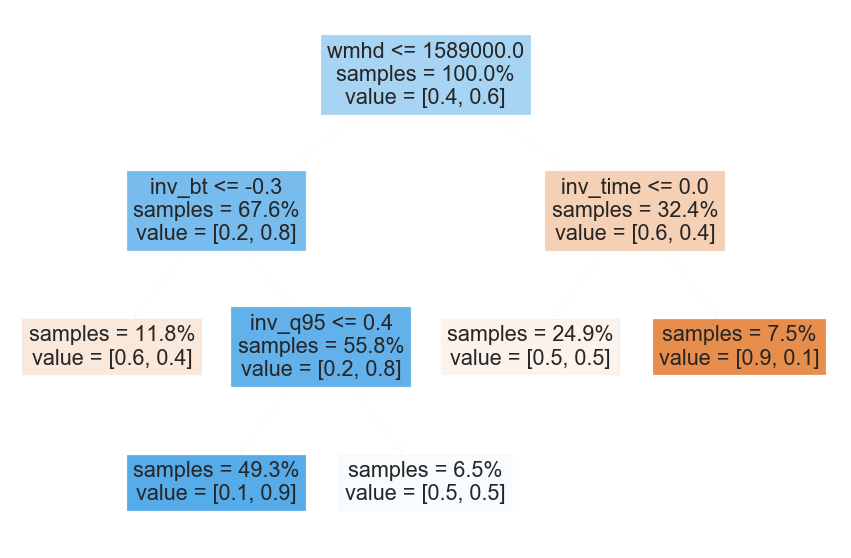

In [42]:
tree_fit = DecisionTreeClassifier(max_depth=3, min_samples_leaf=500, min_impurity_decrease=0.013)
X_tree, y_tree = fix_data(tokamak_data)    
tree_fit.fit(X_tree, y_tree)
plt.figure(figsize=(15,10))
plot_tree(tree_fit, feature_names=X_tree.columns, impurity=False, filled=True, precision=1, proportion=True);

In [46]:
knn_dict = dict(n_neighbors=list(range(1, 20, 2)))

print("uni")
uni_classifier = GridSearchCV(KNeighborsClassifier(weights='uniform'), param_grid=knn_dict, cv=4)
uni_lasso, uni_ridge, uni_scaler, uni_cols, uni_test = train_tree(uni_classifier)

print("dis")
dis_classifier = GridSearchCV(KNeighborsClassifier(weights='distance'), param_grid=knn_dict, cv=4)
dis_lasso, dis_ridge, dis_scaler, dis_cols, dis_test = train_tree(dis_classifier)

print("bay")
bay_classifier = GaussianNB()
bay_lasso, bay_ridge, bay_scaler, bay_cols, bay_test = train_tree(bay_classifier)


uni
[1.0, 0.8790134946486738]
dis
[1.0, 0.8841321544904607]
bay
[0.7532148702361469, 0.7477896696137738]
